# Lab3: LiDAR 3D Cloud classification using Machine Learning

## Prerequisites

$\color{red}{Please\ rename\ your\ Notebook\ before\ starting\ to\ avoid\ push/pull\ issue\ while\ loading\ the\ corrections.}$

$\color{green}{Your\ Notebook\ must\ be\ sent\ after \ the\ second\ lab.}$


**Author**: Antoine Lucas (lucas@ipgp.fr) / Grégory Sainton (sainton@ipgp.fr)

**Update**: 
- v0.1: Oct 2019 (init. version)
- v1.0: Jan 2020 (Notebook version)
- V1.1: Jan 2021 (Corrections and update)
- V1.2: Jan 2021, 25th: fix typo, ternary coordinates errors


**Purpose**: 

We aim at performing a classification over a 3D cloud obtained from ground LiDAR. The technique is based on Brodu & Lague, (2012) paper [1]. The pdf of the paper is available on this GitLab. 
Assuming some considerations about the 3D distribution of objects at various scales, we will compute the eigenvalues (out of PCA) for some training set. Hence we will apply some reference frame transformations, and finally train a classifier. The ultimate goal is to be able to classify a whole data set.

**Data**:
- There are three data sets: 
    1. ``LiDARDunes`` containing a whole vegetated dunes scene with 2 files for training in the `./LiDARDunes/Training/`, `floor.xyz` and `vegetation.xyz`
    2. ``SnowTrees`` containing a whole ski track scene with snowpack and trees. 
    3. ``Forest`` containing a forest scene with bare ground and trees.
    
We will build first our workflow using the ``LiDARDunes``, and applied it on others if you go fast. 

Read the reference paper [1] for additionnal information about the ``LiDARDunes`` data



**Best Practices**
Since Python is now like a second langague, we are going a bit further in the coding best practice. 
1. As you've seen in the previous labs, everything can be coded into a single Notebooks. But in order to improve the readability of the notebook, it' often better to write most of the function into a script file (.py file) and call the library of functions in your notebook.
2. Every function should have a `*docstring*` ie. a documentation describing its purpose, its input and output parameters.
3. Follow as much as possible the `PEP8` convention in coding style.
4. Don't hesitate to catch possible errors (not existing files, empty arrays...) with `try`statement or any conditionnal statement.

**You will learn**:
- How to use PCA to reduce dimensionality;
- How to build ternary plots at different scales;
- Split your data into a training set and a test set;
- How to handle several classification algorithms.




### Organization of the notebook
1. Preprocessing of the data

    1.1. Write a function to read the data
    
    1.2. Write a function to plot those data
    
    
2. Local dimensionality at a given scale

    2.1. PCA computation at each points
    
    2.2. Calculate the ternary coordinates
    
    2.3. Plot the ternary graph 
    
    2.4. Plot the graph for different scales
    
    2.5. Prepare the second training set (i.e., vegetation)
    
    2.6. Concatenate both training sets (vegetation and floor)
    
    
3. Machine Learning classification

    3.1. Now, let's prepare the results of the PCA for ML classification
    
    3.2. Apply classifiers on the data
    
    
4. From the prototype, we will create a PEP-8 python script for Big Data application
    
    4.1. Copy the code section into a single script
    
    4.2. Export as external lib all functions
    
    4.3. Speed-up some steps
    
    4.4. Execute the new worflow on another data set based on the trained algo from initial data set
    
    4.5. Discuss the results
    
    
----------------

#### Before going further, execute the following cell to import all the necessary libraries for the lab.

In [65]:
import numpy as np
from numpy import savetxt
import pandas as pd

In [66]:
# Internal Library associated to this lab.
#
# Please note that if you make any modification in this library, 
# you need to restart the Kernal of your notebook to take the 
# changes into account (Kernel -> Restart or Restart and Clear Output)
from libLab3_Lidar import *

## 1. Preprocessing

### 1.1 Write a function to read the data
The files are made with 3 columns.
Your function must follow the following model: 
```python
    def readData(filename):
        """
        Function to read the landscape data
        INPUT:
        ------
            @filename: string
        
        OUTPUT:
        -------
            x, y, z: numpy arrays
        
        """
```

**hint**
- We suggest you to use ``np.genfromtxt(filename, delimiter=' ')`` to read the *.xyz files
- Since you return three objects, you need to use three objects while calling the function:
```python
    dx1, dy1, dz1 = readData(filename)
```

In [67]:
# WRITE YOUR CODE HERE

#### Solution

In [68]:
# Solution in libLab3_Lidar.py

#### Open one file with your function `readData`    

In [69]:
# WRITE YOUR CODE HERE
workingdir='./LiDARDunes/training/'
filename=workingdir+'floor.xyz'
dx1, dy1, dz1 = readData(filename)

### 1.2. Plot function
- to plot your data into (x, y, z) in a 3D scatter plot
    
```python
    def plot_figs(dx, dy, dz, density=2):

```

- Optionnaly, one can add  the `elevation` and the `azimuth` parameters to change the point of view of your plot.
- `density` option will be your decimation factor.
- One easy way to decimate a numpy array with a decimation factor `d` is the following:
```python
    myarray_decim = myarray[::d]
```



**hints**
- For your 3D plot, we consider using `Axes3D` from the`mpl_toolkits.mplot3d` library.


In [70]:
# Solution in libLab3_Lidar.py

#### Plot your dataset

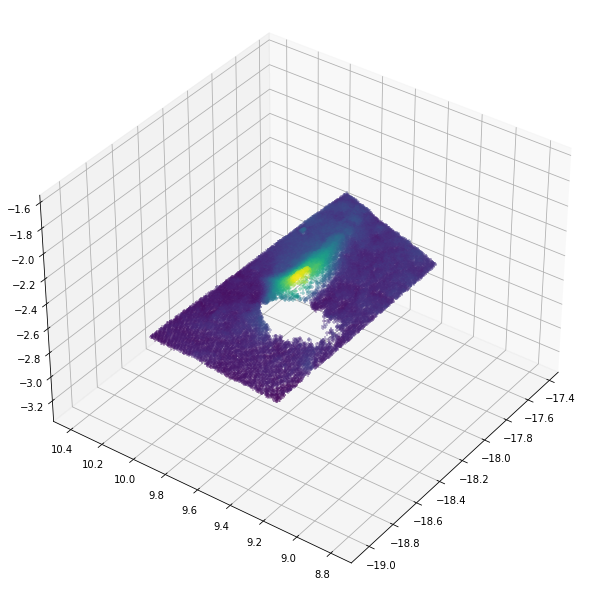

In [71]:
# WRITE YOUR CODE HERE
elev = 36
azim = -144
density = 2

plot_figs(0, elev, azim, dx1,dy1,dz1, density=density)

##### Solution 

Here is an example with an elevation and an azimuth. We also applied a decimation factor.

Feel free to test several combinations of parameters 

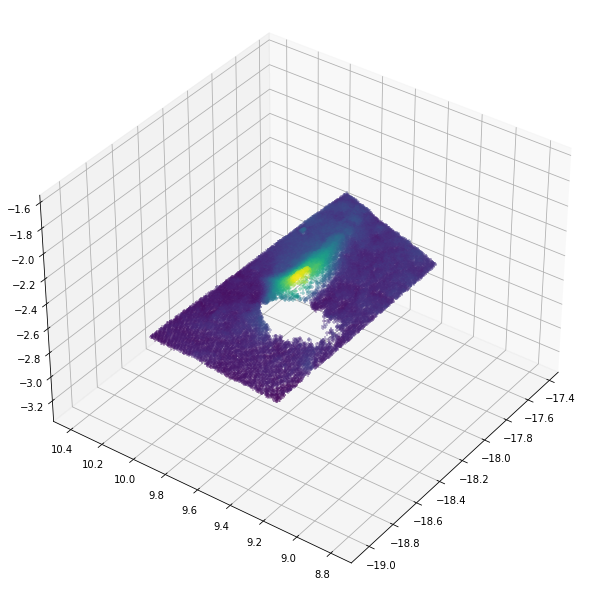

In [72]:
elev = 36
azim = -144
density = 2

plot_figs(0, elev, azim, dx1,dy1,dz1, density=density)

## 2. Local dimensionality at a given scale

As written in the article, the main idea is to characterize the local dimensionality properties for **each point** at **different scales** $s$.
Let's consider $s$ as the diameter of a ball centered on a given point of interest. One can compute a neighborhood ball any scale of interest for each point of the scene. 

To find the most relevant directions in the neighborhood ball, we are using PCA to maximize the variance between the neighbors (see Lab1 for details), 


<img src="Figures/NeighboorBall.png" width="800">

So, in short, the next step is to estimate the PCA for each point $(X,Y,Z)$, center of a neighborhood ball with a diamater $s$


### 2.1 PCA computation at each points
#### Questions

- Create a function that estimate the PCA and returns the eigenvalues of every points within a scale distance "s"

**hints**
- Anticipate in your function the fact that you will have to decimate your data
- Center your vectors X, Y, Z by removing the mean value (`np.mean(...)`)
- With the commands `spatial.distance.pdist` and `spatial.distance.squareform` compute all the distances from one point to the others.
- For each point
    - Select all the points within the diameter $s$ 
    - Estimate the PCA from explained variance ratio
    - Keep the eigenvalues in an array
    
- PCA documentation is here https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA


In [73]:
# WRITE YOUR CODE HERE OR IN EXTERNAL LIB

#### Solution

In [74]:
# Solution in libLab3_Lidar.py

##### Test on the first values. 
Never hesitate to add some extra cells to get some partial results
Here, before going further, it's better to have a look on the output structure of the function you just wrote.



In [75]:
eigv = getEigenvaluePCA(dx1, dy1, dz1, 0.1, decim=2)
print(eigv[:5])

Data are decimed by a factor of  2
shape of Y  (20035, 3)
  Treating distance of 0.1 m
[[0.60055902 0.3980315  0.00140948]
 [0.69209054 0.30659606 0.0013134 ]
 [0.52890793 0.46899997 0.0020921 ]
 [0.52890793 0.46899997 0.0020921 ]
 [0.77465909 0.22411867 0.00122225]]


### 2.2 Calculate the ternary coordinates

Using the following formula, we are able to transform the eigenvalues to plot them into a ternary graph.

<center><img src = "Figures/2D_ParameterSpace_Ternary.png" witdh = "300"></center>


#### Questions
- Write a function `estimateTernaryCoord` which estimate the ternary component for each points.
- The function will return the list of coordinates

```python
    def estimateTernaryCoord(comp):
        ...
        return X, Y, pdf

```

x_ter and y_ter being from the figure above.
z_ter, being the density obtained from 

- `np.vstack([X, Y])` and 
- the scipy function `gaussian_kde`.


In [76]:
# WRITE YOUR CODE HERE OR IN EXTERNAL LIB

#### Solutions

In [77]:
 # Solution in libLab3_Lidar.py

### 2.3. Plot the ternary graph

Using the coordinates estimated in the previous question, plot the ternary graph. 
```python
   def plotTernary(x, y, z, title):  
        ...
```
**hints**: `tri.Triangulation`, `tri.UniformTriRefiner`, `.refine_triangulation` and `plt.triplot` could be usefull...

In [78]:
# Solution in libLab3_Lidar.py

### 2.4. Plot the graph for different scales

#### Questions
Since all the pieces of the puzzle are done: 

- Plot the ternary graph for several scales for example $10$ cm and $30$ cm with a decimation factor equal to $4$;
- Create a Pandas DataFrame `floor` with the 3 ternary components for each dimensions. The coordinates of both dimensions must be concatenated horizontally using `pd.concat([..., ...], axis=1)`;
- Add a column full of $1$ to identify the data from the first file. This column will be used as a label column.


**hint**

Here is the header of the expected DataFrame `floor` after concatenation and after adding the field `class`:

|x_ter_0.1|y_ter_0.1|z_ter_0.1|x_ter_0.3|y_ter_0.3|z_ter_0.3|class|
|---------|---------|---------|---------|---------|---------|-----|




In [79]:
# WRITE YOUR CODE HERE

#### Solution

Data are decimed by a factor of  2
shape of Y  (20035, 3)
  Treating distance of 0.1 m


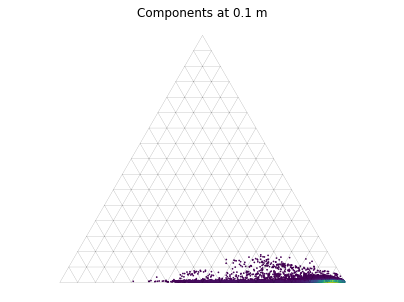

Data are decimed by a factor of  2
shape of Y  (20035, 3)
  Treating distance of 0.3 m


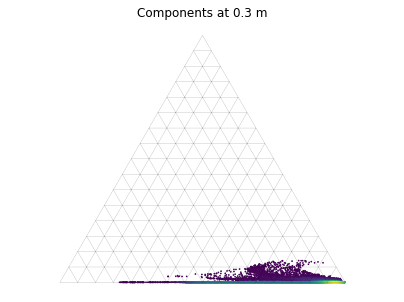

In [80]:
# All together
dims = [0.1, 0.3]
floor = pd.DataFrame()

# We are testing the previous functions at 10cm and at 30 cm diameter
for dim in dims:
    eigv = getEigenvaluePCA(dx1, dy1, dz1, dim, decim=2)
    x_ter, y_ter, z_ter = estimateTernaryCoord(eigv)
    data_dim = pd.DataFrame({'x_ter_'+str(dim):x_ter,  # We concatenate the name of the axis and the dimension 
                             'y_ter_'+str(dim):y_ter, 
                             'z_ter_'+str(dim):z_ter})
    
    floor = pd.concat([floor, data_dim], axis=1)       # DataFrame for each dim are stacked together
    title = "Components at "+str(dim)+" m"
    plotTernary(x_ter, y_ter, z_ter, title)
floor["class"] = 1

Example of `head` for the DataFrame `floor'

<img src="./Figures/floorDataFrame.png" width = "400">

#### Comments
Interestingly, the center of mass is clearly close to a pure 2D distribution. 
But when looking at 10cm, we detect the ripples, while at 30cm the dune (and it's avalanche face) is detectable.

### 2.5 Prepare the second training set (i.e., vegetation)

In order to prepare our further classifiers, we need another dataset representing another type of data. 

In the directory `./LiDARDunes/Training/`, there is a file called `vegetation.xyz`.

#### Questions
1. Open the file just like you did with `floor.xyz`
2. Apply the steps 2.1 to 2.4 to your second file. 
3. The DataFrame will be named `veget` and the column `class` will be full of $2$. 


In [81]:
# WRITE YOUR CODE HERE

#### Solution 

Data are decimed by a factor of  2
shape of Y  (2304, 3)
  Treating distance of 0.1 m


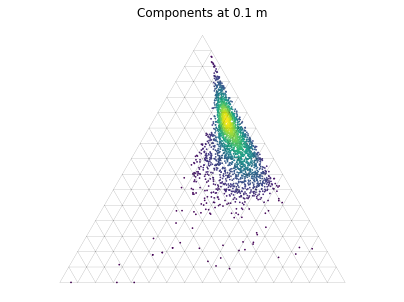

Data are decimed by a factor of  2
shape of Y  (2304, 3)
  Treating distance of 0.3 m


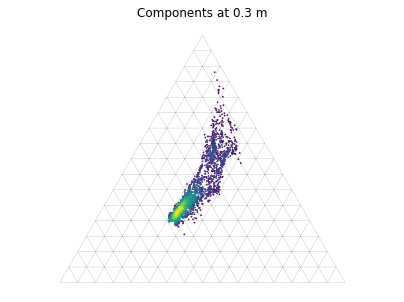

In [82]:
workingdir='./LiDARDunes/training/'
filename=workingdir+'vegetation.xyz'
dx, dy, dz = readData(filename)

# All together
dims = [0.1, 0.3]
veget = pd.DataFrame()

for dim in dims:
    eigv = getEigenvaluePCA(dx, dy, dz, dim, decim=2)
    x_ter, y_ter, z_ter = estimateTernaryCoord(eigv)
    data_dim = pd.DataFrame({'x_ter_'+str(dim):x_ter, 
                             'y_ter_'+str(dim):y_ter, 
                             'z_ter_'+str(dim):z_ter})
    
    veget = pd.concat([veget, data_dim], axis=1)
    title = "Components at "+str(dim)+" m"
    plotTernary(x_ter, y_ter, z_ter, title)
veget["class"] = 2

#### Comments
Interestingly, the center of mass is moving from a 3D distribution towards a more ellongated shape from 10 cm to 30 cm. 
This is due to the whole shape of the vegetation, which is ellongated at a scale greater than 20cm.

### 2.6. Concatenate both training sets

#### Question

Using the function `pd.concat(...)`, concatenate the two DataFrame `floor` and `veget`.


In [83]:
# WRITE YOUR CODE HERE
data = pd.DataFrame()
# Go on...

#### Solution

In [84]:
data = pd.DataFrame()
data = pd.concat([veget, floor])          # Again, we use pd.concat() but the stack is vertical 
                                          # (implicit axis=0 option)
display(data)

x_ter_0.1  y_ter_0.1   z_ter_0.1  x_ter_0.3  y_ter_0.3   z_ter_0.3  \
0       0.577420   0.483490   20.471241   0.568823   0.523666   10.308108   
1       0.520036   0.512300    4.805791   0.525890   0.419616   22.145738   
2       0.464965   0.190388    0.197183   0.571654   0.548138    6.326416   
3       0.545500   0.552314   13.701594   0.577539   0.584702    3.375905   
4       0.521634   0.337803    2.519892   0.567692   0.550432    6.637395   
...          ...        ...         ...        ...        ...         ...   
20030   0.869683   0.006438  100.852095   0.866639   0.001924  240.493628   
20031   0.803023   0.005464   49.385676   0.861786   0.001889  236.713431   
20032   0.856733   0.006733   61.071634   0.859846   0.002147  222.138573   
20033   0.862065   0.006748   71.435424   0.846397   0.002068  215.009921   
20034   0.858108   0.009027   36.817790   0.845116   0.002360  197.131655   

       class  
0          2  
1          2  
2          2  
3          2  
4          2  
...      ...  
20030      1  
20031      1  
20032      1  
20033      1  
20034      1  

[22339 rows x 7 columns]

## 3. Machine Learning classification

In this section, we will use all the preprocessing done in the section 1. and 2. to compare several classification algorithms on the data. 

You will explore several functions of the `sci-kit learn` library. Don't hesitate to have a look on the [https://scikit-learn.org/stable/index.html](dedicated web site) to find informations about the functions, about the parameters and espacially the[https://scikit-learn.org/stable/supervised_learning.html#supervised-learning](classification part)



### 3.1 Now, let's prepare the results of the PCA for ML classification

1. Split the dataframe into X,y variables, X being the features, y being the class. 
    You can use ``pd.drop()`` for the X.
    
2. Split this data sets into training and testing subsets with ``train_test_split`` command. We suggest a ``test_size=.25``.

In [85]:
# WRITE YOUR CODE HERE

#### Solution

In [86]:
data = data.dropna()

X = data.drop({"z_ter_0.1","z_ter_0.3","class"}, axis=1)
y = data["class"].copy()

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 3.2 Apply classifiers on the data

We remind that the goal of the classifiers is to `predict` a `label` choosen among a predefined list of labels. 

In the following sections, you will try several classifiers. The way to do it is always the same:

1. Import the classifier 
2. Instanciate your classifier
3. Fit the model with the training set
4. Predict the result on the test set
5. Check the quality of the result using:
    - 5.1. The confusion matrix
    - 5.2. The accuracy score
6. Plot the contours

Just a piece of code as example:
```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
myModel = LinearDiscriminantAnalysis(...)
myModel.fit(X_train, y_train)

y_pred = myModel.predict(X_test)

confusion_matrix(...)
myModel.score(...)

```


#### Confusion matrix 

The confusion matrix is a convenient way to evaluate the performances of a classifier. 
To understand the confusion matrix better, please refer to the lecture 2.

##### Function to plot the confusion matrix

To plot the confusion matrix in a pretty way, you will use the `plot_confusion_matrix` function from `sklearn.metrics`

An example of plot of the confusion matrix is given [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

#### 3.2.1 Linear Discriminant Analysis

As a first example, we propose you to apply the `Linear Discriminant Analysis` classifier. 

The principle is to model the distribution of each predictive variable by a Gaussian probability law which depends on the class to be predicted and to calculate the parameters of these probability laws. Then, during the prediction, we apply Bayes' law to deduce the probability of each class knowing the values of the predictor variables. In the LDA, the boundaries between predicted classes are in fact linear. 

##### Questions

1. Apply the recipe given above
2. Print the scores of the fit on the train, test and full set
3. Plot the confusion matrix. 
4. Plot the contours.


**hints**

To plot the contours and boundaries of your classifiers, we made two differents functions. 

- `plot_contours(...)` which allow you to plot contour of a single classifier
- `plot_contours_compare(...)` which allow you to plot the contours for several classifiers
These two functions are already developped for you and written in the associated libLab3_Lidar.py

- To get help on a function: `myfunction?` or `help(plot_contours)`

In [89]:
# WRITE YOUR CODE HERE

##### Solution

Classifier: Linear Discriminant Analysis

Accuracy on the train data: 100.00%
Accuracy on test data: 100.00%
Accuracy on the whole data: 100.00%
 


/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


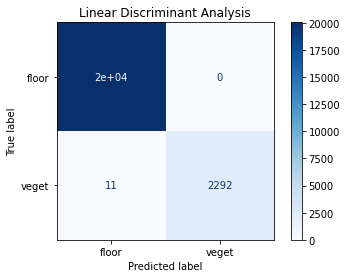

In [90]:
className="Linear Discriminant Analysis"

# Instanciate, fit and predict
lda = LinearDiscriminantAnalysis(store_covariance=True)
classifierLDA = lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
y_pred_all = lda.predict(X)
y_pred_train = lda.predict(X_train)
y_pred = lda.fit(X, y.ravel()).predict(X)

# Print the score of the classifier
print(f"Classifier: {className}\n")
print("Accuracy on the train data: {:.2f}".format(lda.score(X_train, y_pred_train)*100)+"%")
print("Accuracy on test data: {:.2f}".format(lda.score(X_test, y_pred_lda)*100)+"%")
print("Accuracy on the whole data: {:.2f}".format(lda.score(X, y_pred_all)*100)+"%")
print(" ")

#Confusion matrix

class_names = ["floor", "veget"]
disp = plot_confusion_matrix(classifierLDA, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = None)
disp.ax_.set_title(className)
plt.show()

# Contours plot
# plot_contours(X_train.to_numpy(), y_train.to_numpy(), lda)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

##### Example of output for LDA

<img src="./Figures/ConfusionMatrixLDA.png" width="300">
<img src="./Figures/ContoursPlotLDA.png" width="300">


#### 3.2.2 Linear SVM

This classifier is the one used and proposed by Brody & Lague, 2012 (reference on top of the lab.)



In [91]:
# WRITE YOUR CODE HERE

##### Solution

Classifier: Decision Tree
Accuracy on the train data: 99.97%
Accuracy on test data: 100.00%
Accuracy on the whole data: 99.98%
 


/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


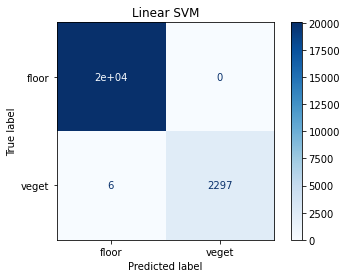

/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


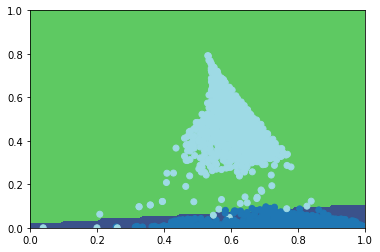

In [92]:
from sklearn.svm import SVC
className="Linear SVM" 

svm =  SVC(kernel="linear", C=0.025)
classifierSVM = svm.fit(X_train, y_train)
y_pred_dt = svm.predict(X_test)


print("Classifier: Decision Tree")
print("Accuracy on the train data: {:.2f}".format(svm.score(X_train, y_pred_train)*100)+"%")
print("Accuracy on test data: {:.2f}".format(svm.score(X_test, y_pred_dt)*100)+"%")
print("Accuracy on the whole data: {:.2f}".format(svm.score(X, y_pred_all)*100)+"%")
print(" ")

class_names = ["floor", "veget"]
disp = plot_confusion_matrix(classifierSVM, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = None)
disp.ax_.set_title(className)
plt.show()

# Contours plot
plot_contours(X_train.to_numpy(), y_train.to_numpy(), lda,0.01,500)
#plot_contours(X_train.to_numpy(), y_train.to_numpy(), lda)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

#### 3.2.3 Decision Tree

In [93]:
# WRITE YOUR CODE HERE

##### Solution

Classifier: Decision Tree
Accuracy on the train data: 100.00%
Accuracy on test data: 100.00%
Accuracy on the whole data: 100.00%
 


/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


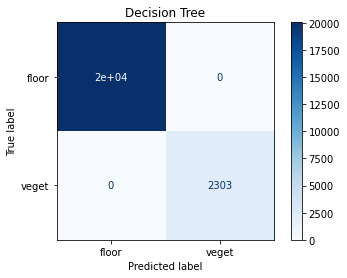

In [94]:
className="Decision Tree"
dt = DecisionTreeClassifier()
classifierDT = dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_pred_all = dt.predict(X)
y_pred_train = dt.predict(X_train)
y_pred = dt.fit(X, y.ravel()).predict(X)


print("Classifier: Decision Tree")
print("Accuracy on the train data: {:.2f}".format(dt.score(X_train, y_pred_train)*100)+"%")
print("Accuracy on test data: {:.2f}".format(dt.score(X_test, y_pred_dt)*100)+"%")
print("Accuracy on the whole data: {:.2f}".format(dt.score(X, y_pred_all)*100)+"%")
print(" ")

class_names = ["floor", "veget"]
disp = plot_confusion_matrix(classifierDT, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = None)
disp.ax_.set_title(className)
plt.show()


# Contours plot
# plot_contours(X_train.to_numpy(), y_train.to_numpy(), lda)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

#### 3.2.4 Quadratic Discriminant Analysis

In [95]:
# WRITE YOUR CODE HERE

##### Solution

Classifier: Quadratic Discriminant Analysis
Accuracy on the train data: 99.98%
Accuracy on test data: 100.00%
Accuracy on the whole data: 99.98%
 


/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


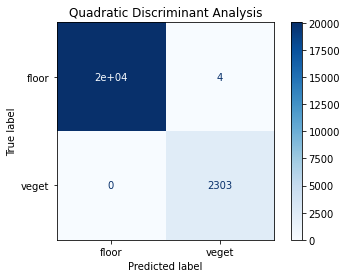

In [96]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

className="Quadratic Discriminant Analysis"
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
classifierQDA = qda.fit(X_train, y_train)
y_pred_dt = qda.predict(X_test)

print("Classifier: Quadratic Discriminant Analysis")
print("Accuracy on the train data: {:.2f}".format(qda.score(X_train, y_pred_train)*100)+"%")
print("Accuracy on test data: {:.2f}".format(qda.score(X_test, y_pred_dt)*100)+"%")
print("Accuracy on the whole data: {:.2f}".format(qda.score(X, y_pred_all)*100)+"%")
print(" ")

class_names = ["floor", "veget"]
disp = plot_confusion_matrix(classifierQDA, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = None)
disp.ax_.set_title(className)
plt.show()


# Contours plot
# plot_contours(X_train.to_numpy(), y_train.to_numpy(), lda)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

#### 3.2.5 Radial Basis Function kernel (RBF)

In [97]:
# WRITE YOUR SOLUTION

##### Solution

Classifier: Quadratic Discriminant Analysis
Accuracy on the train data: 100.00%
Accuracy on test data: 100.00%
Accuracy on the whole data: 100.00%
 


/Users/alucas/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


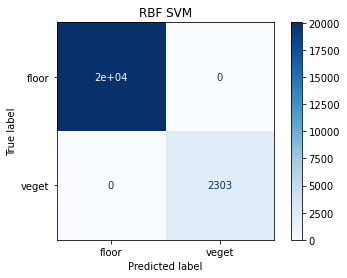

In [98]:

className="RBF SVM"
rbf =    SVC(gamma=2, C=1)
classifierRBF = rbf.fit(X_train, y_train)
y_pred_dt = rbf.predict(X_test)

print("Classifier: Quadratic Discriminant Analysis")
print("Accuracy on the train data: {:.2f}".format(rbf.score(X_train, y_pred_train)*100)+"%")
print("Accuracy on test data: {:.2f}".format(rbf.score(X_test, y_pred_dt)*100)+"%")
print("Accuracy on the whole data: {:.2f}".format(rbf.score(X, y_pred_all)*100)+"%")
print(" ")

class_names = ["floor", "veget"]
disp = plot_confusion_matrix(classifierRBF, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = None)
disp.ax_.set_title(className)
plt.show()

# Contours plot
# #plot_contours(X_train.to_numpy(), y_train.to_numpy(), rbf)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

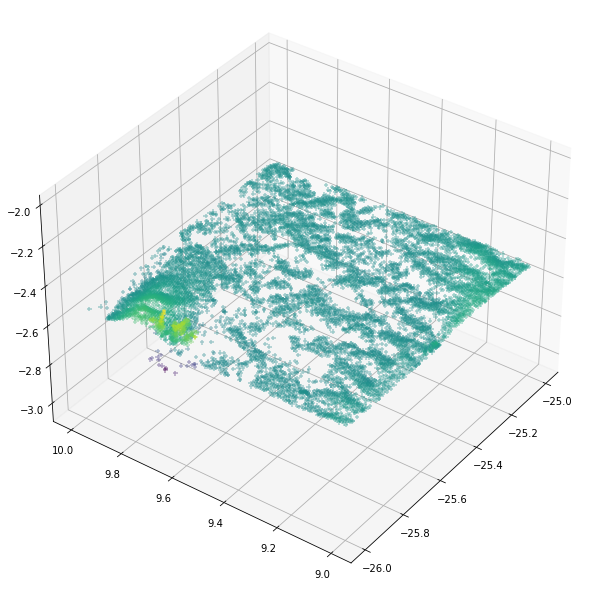

In [99]:
dx1, dy1, dz1 = readData('./LiDARDunes/data/scene5.xyz')

elev = 36
azim = -144
density = 2

plot_figs(0, elev, azim, dx1,dy1,dz1, density=density)


In [100]:
dims = [0.1, 0.3]
decim = 2
SceneFeature = pd.DataFrame()

for dim in dims:
    eigv = getEigenvaluePCA(dx1, dy1, dz1, dim, decim=decim)
    x_ter, y_ter, z_ter = estimateTernaryCoord(eigv)
    data_dim = pd.DataFrame({'x_ter_'+str(dim):x_ter, 
                             'y_ter_'+str(dim):y_ter, 
                             'z_ter_'+str(dim):z_ter})
    
    SceneFeature = pd.concat([SceneFeature, data_dim], axis=1)
    title = "Components at "+str(dim)+" m"

Data are decimed by a factor of  2
shape of Y  (9382, 3)
  Treating distance of 0.1 m
Data are decimed by a factor of  2
shape of Y  (9382, 3)
  Treating distance of 0.3 m


In [101]:
#X = SceneFeature.drop({"z_ter_0.1","z_ter_0.3"}, axis=1)

ScenePosition = pd.DataFrame({'X':dx1[::decim], 
                             'Y':dy1[::decim], 
                             'Z':dz1[::decim]})


SceneFeature  = pd.concat([SceneFeature, ScenePosition], axis="columns")                             
                             
#SceneFeature 

SceneFeature = SceneFeature.dropna()

X = SceneFeature.drop({"z_ter_0.1","z_ter_0.3","X","Y","Z"}, axis=1)

y_class_scene = lda.predict(X)

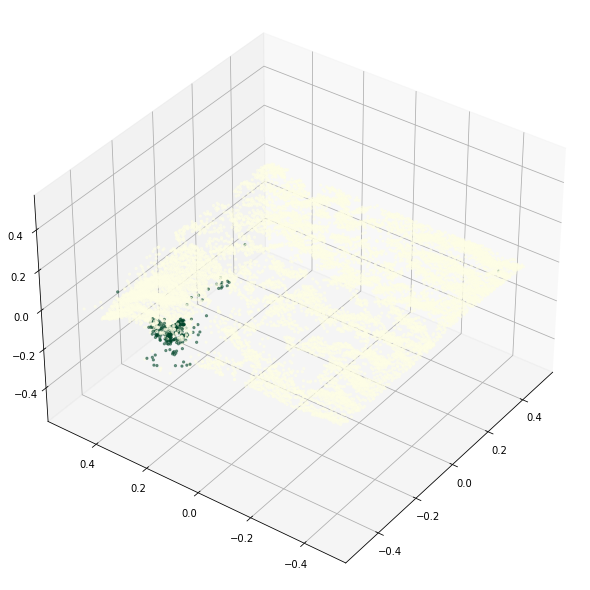

In [102]:

plot_3dcladd(SceneFeature["X"],SceneFeature["Y"],SceneFeature["Z"],y_class_scene,1)

## References

This lab is based on the following article
1. Bordu & Lague, 2012, 3D terrestrial lidar data classification of complex natural scenes using a multi-scale dimensionality criterion: Applications in geomorphology, ISPRS Journal of Photogrammetry and Remote Sensing, doi:10.1016/j.isprsjprs.2012.01.006 | https://pss-gitlab.math.univ-paris-diderot.fr/dralucas/earth-data-science/blob/master/Bib/BroduLague_ISPRS.pdf